In [1]:
import numpy as np
from catboost import CatBoostClassifier, datasets
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


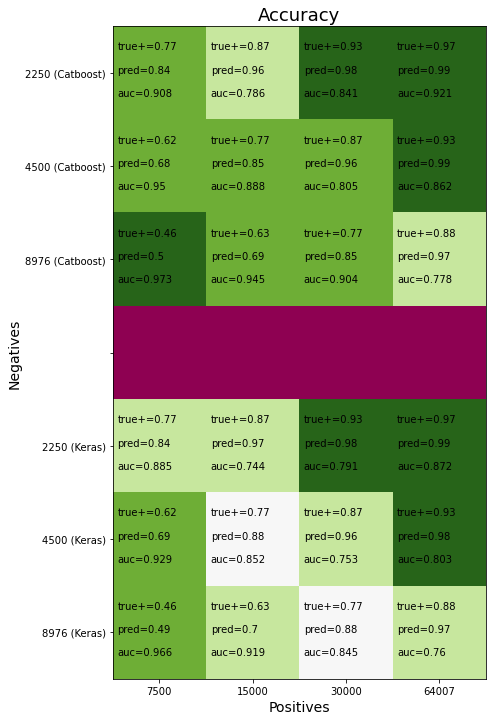

In [2]:
import re

from base_experiment import BaseExperiment

def clean_string(s):
    return re.sub('[^A-Za-z0-9]+', "_", str(s))


class KickExperiment(BaseExperiment):
    POSITIVE_STEPS = [7500, 15000, 30000, 64007]
    NEGATIVE_STEPS = [2250, 4500, 8976]

    def get_dataset(self):
        data = pd.read_csv("kick.csv")
        target = data["IsBadBuy"].apply(lambda x: 1.0 if x == 0 else 0)
        data["PurchYear"] = pd.DatetimeIndex(data['PurchDate']).year
        data["PurchMonth"] = pd.DatetimeIndex(data['PurchDate']).month
        data["PurchDay"] = pd.DatetimeIndex(data['PurchDate']).day
        data["PurchWeekday"] = pd.DatetimeIndex(data['PurchDate']).weekday
        data.drop(["RefId", "IsBadBuy", "PurchDate"], axis=1, inplace=True)
        categorical_features = {0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 23, 24, 25, 26, 27, 29, 31, 32, 33, 34}
        for i in categorical_features:
            data[data.columns[i]] = data[data.columns[i]].apply(clean_string)
        columns_to_impute = []
        for i, column in enumerate(data.columns):
            if i not in categorical_features and pd.isnull(data[column]).any():
                columns_to_impute.append(column)
        for column_name in columns_to_impute:
            data[column_name + "_imputed"] = pd.isnull(data[column_name]).astype(float)
            data[column_name].fillna(0, inplace=True)
        for i, column in enumerate(data.columns):
            if i not in categorical_features:
                data[column] = data[column].astype(float)
        return data, target, [data.columns[x] for x in categorical_features]
    
    def get_keras_model(self):
        return keras.Sequential([
            keras.layers.Dense(32, activation='relu'),
            keras.layers.Dropout(0.25),
            keras.layers.Dense(32, activation='relu'),
            keras.layers.Dropout(0.25),
            keras.layers.Dense(16, activation='relu'),
            keras.layers.Dropout(0.25),
            keras.layers.Dense(1, activation='sigmoid'),
        ])
    
KickExperiment().run()